# Video search using CLIP

Download video from youtube and check simlirarity on every frame. Returns top k results per queries.

Copied code from 
- https://huggingface.co/spaces/h4d35/VideoSearch (it's broken now 2022/4/6)
- https://github.com/openai/CLIP

In [1]:
%pip install git+https://github.com/openai/CLIP.git -q
%pip install ftfy regex  tqdm -q
%pip install "opencv-python-headless<4.3" -q
%pip install yt-dlp matplotlib numpy -q

     |████████████████████████████████| 53 kB 1.1 MB/s 
     |████████████████████████████████| 21.6 MB 1.3 MB/s 
     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 34.5 MB/s 
     |████████████████████████████████| 357 kB 41.6 MB/s 
     |████████████████████████████████| 111 kB 48.1 MB/s 
     |████████████████████████████████| 218 kB 47.0 MB/s 


In [2]:
import os
import cv2
from PIL import Image
import clip
import torch
import math
import numpy as np
import torch
import datetime
import yt_dlp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

In [3]:
def download_ytb(link):
    vid = link.split('?v=')[-1]
    ydl_opts = {
        'outtmpl': f'{vid}.mp4',
        'quiet': True,
        'ignoreerrors': True,
        'format': '136',  # 136 for mp4 1280x720 25fps no audio
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([link])
    return vid

In [4]:
# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  

def inference(video, text, topk=1):
    # The frame images will be stored in video_frames
    video_frames = []
    # Open the video file
    
    capture = cv2.VideoCapture(video)
    fps = capture.get(cv2.CAP_PROP_FPS)
    
    current_frame = 0
    # Read the current frame
    ret, frame = capture.read()
    while capture.isOpened() and ret:
        ret,frame = capture.read()
        current_frame += 1
        if ret:
            video_frames.append(Image.fromarray(frame[:, :, ::-1]))
    capture.release()

    # Print some statistics
    print(f"Frames extracted: {len(video_frames)}")
    
    # You can try tuning the batch size for very large videos, but it should usually be OK
    batch_size = 100
    batches = math.ceil(len(video_frames) / batch_size)
    
    # The encoded features will bs stored in video_features
    video_features = torch.empty([0, 512], dtype=torch.float16).to(device)
    # Process every 5 frames
    interval = 10 
    # Process each batch
    print(f"Processing batches")
    for i in tqdm(range(batches)):
        # Get the relevant frames
        batch_frames = video_frames[i*batch_size : (i+1)*batch_size: interval]
        
        # Preprocess the images for the batch
        batch_preprocessed = torch.stack([preprocess(frame) for frame in batch_frames]).to(device)
        
        # Encode with CLIP and normalize
        with torch.no_grad():
            batch_features = model.encode_image(batch_preprocessed)
            batch_features /= batch_features.norm(dim=-1, keepdim=True)
    
        # Append the batch to the list containing all features
        video_features = torch.cat((video_features, batch_features))
    
    # Print some stats
    print(f"Features: {video_features.shape}")
 
    search_query=text
    display_heatmap=False
    # Encode and normalize the search query using CLIP
    with torch.no_grad():
        text_features = model.encode_text(torch.cat(
            [clip.tokenize(f"a photo of a person doing {query}") for query in search_query]).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute the similarity between the search query and each frame using the Cosine similarity
    similarities = (100.0 * video_features @ text_features.T).softmax(dim=-1)
    print('similarity shape', similarities.shape)
    values, best_photo_idx = similarities.topk(topk, dim=0, sorted=True)
    seconds = []
    # best_photo_idx[i][j] is the index of the j-th largest prob for query[i]
    best_photo_idx = best_photo_idx.cpu()*interval
    
    frames_per_query = []
    sec_per_query = []
    for top in best_photo_idx:
        frames = []
        seconds = []
        for i in top:
            frame = video_frames[i]
            frames.append(frame)
        # Find the timestamp in the video and display it
            sec = round(i.numpy()/fps)
            seconds.append(sec)
        sec_per_query.append(seconds)
        frames_per_query.append(frames)
    del video_frames
    gc.collect()
    return frames_per_query, sec_per_query, similarities
  

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 120MiB/s]


In [5]:
link = 'https://www.youtube.com/watch?v=3OZ2MT_5r3Q' #@param {type:"string"}
vid = download_ytb(link)

[download] 100% of 2.71MiB in 00:00                                                  

In [6]:
queries = ['squat', 'bicep curl', 'push up', 'pull up', 'shoulder press'] #@param {type:"string"}
video = f'{vid}.mp4'
topk =  3 #@param {type: "number"}
frames_per_query, sec_per_query, sims = inference(video, queries, topk=topk)

Frames extracted: 1544
Processing batches


  0%|          | 0/16 [00:00<?, ?it/s]

Features: torch.Size([155, 512])
similarity shape torch.Size([155, 5])


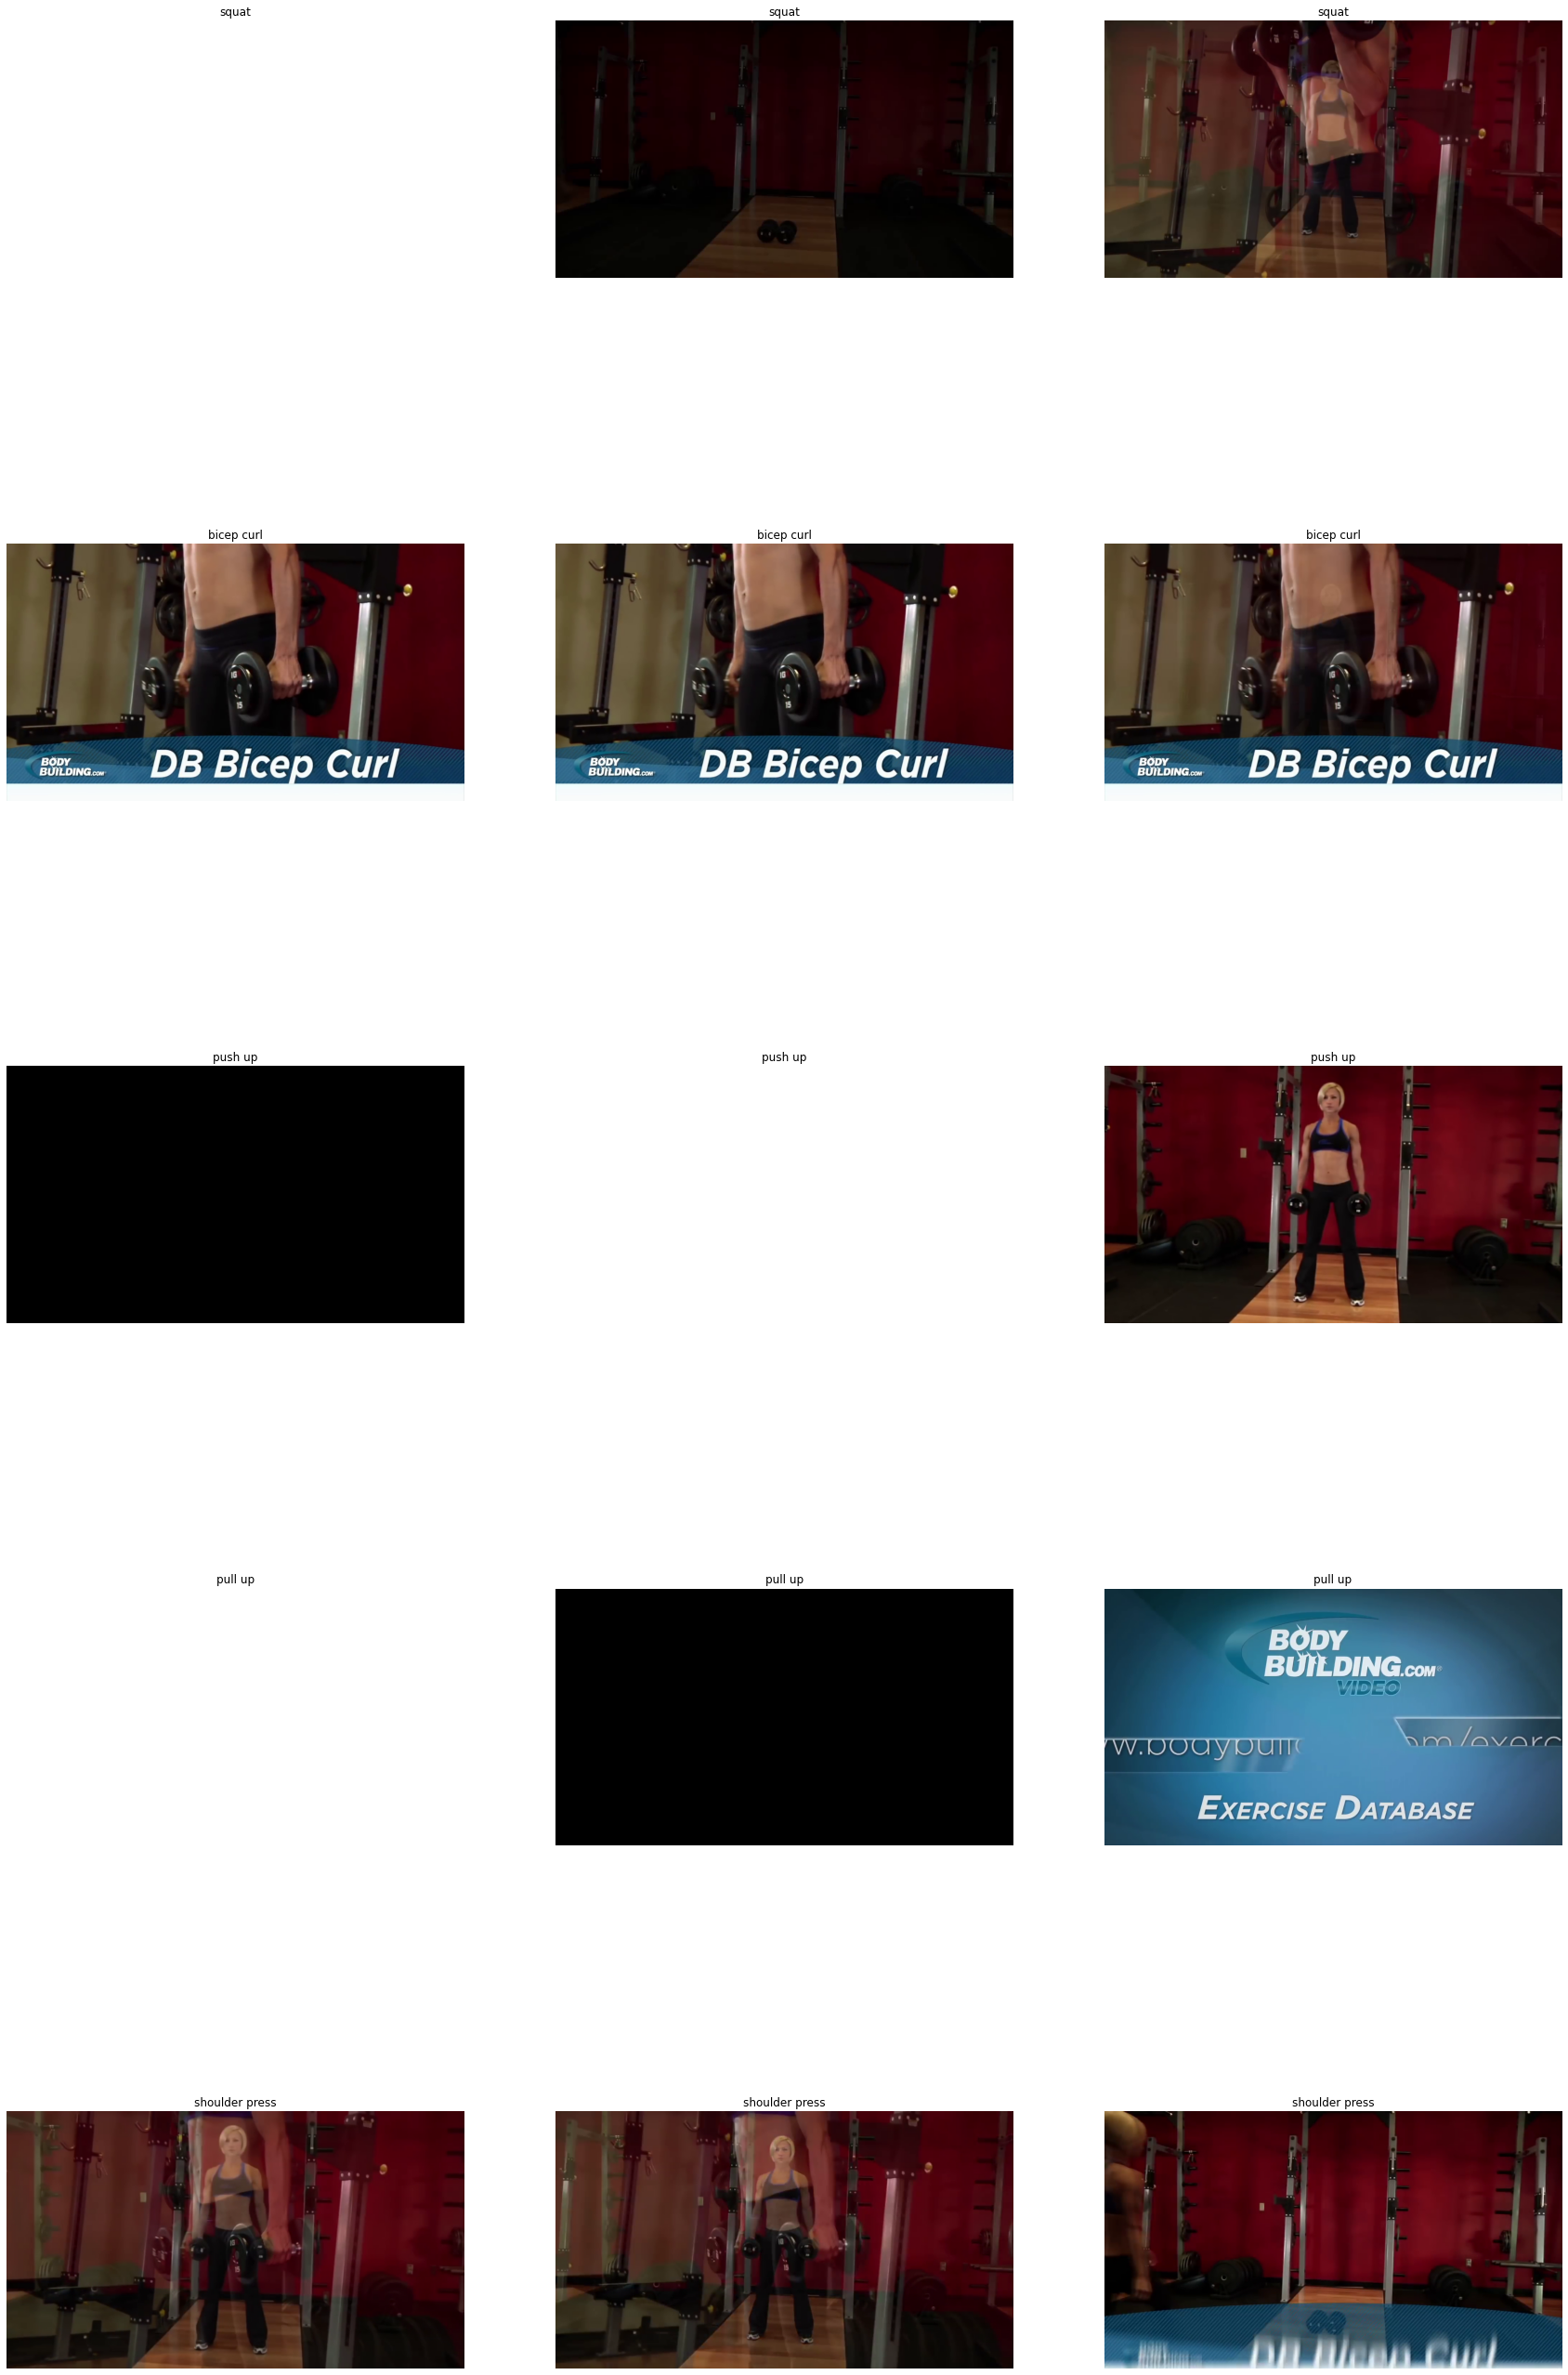

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(30, 50))
for i, query in enumerate(queries):
    for j in range(topk):
        frame = frames_per_query[j][i]
        axes[i, j].set_title(f'{query}')
        axes[i, j].imshow(frame)
        axes[i, j].set_axis_off()
plt.show()
# fig.savefig('topk.png', dpi=200)